In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# The token can be used to access the repository
!git clone https://github.com/cariello1/BIO-NER-.git

Cloning into 'BIO-NER-'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 375 (delta 2), reused 0 (delta 0), pack-reused 365
Receiving objects: 100% (375/375), 9.98 MiB | 23.98 MiB/s, done.
Resolving deltas: 100% (188/188), done.


In [ ]:
%cd /content/BIO-NER-

/content/BIO-NER-


In [ ]:
%%capture
!pip install tensorflow==2.3

In [ ]:
%%capture
import tensorflow as tf

In [ ]:
tf.__version__

'2.3.0'

In [ ]:
%%capture
# CRF layer for tensorflow 2 supportig keras masking
!pip install tf2crf

In [ ]:
from preprocessing_1 import PreprocessingDocsNN
from preprocessing_1 import read_data

# PREPROCESSING

In [ ]:
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
from matplotlib import pyplot as plt
from tqdm import tqdm
import random as rn

In [ ]:
# For reproducibility
seed = 937
np.random.seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
# Original data in IOB format
file1_train = "/content/drive/MyDrive/BIO-NER-project/BC4CHEMD-IOB/BC4CHEMD/train.tsv"
file2_test = "/content/drive/MyDrive/BIO-NER-project/BC4CHEMD-IOB/BC4CHEMD/test.tsv"
file3_dev = "/content/drive/MyDrive/BIO-NER-project/BC4CHEMD-IOB/BC4CHEMD/devel.tsv"

In [ ]:
input_train = read_data(file1_train)
input_test = read_data(file2_test)
input_dev = read_data(file3_dev)

Total number of sentences: 30682 
Total number of sentences: 26364 
Total number of sentences: 30639 


In [ ]:
docs_train = PreprocessingDocsNN(input_train)
docs_test = PreprocessingDocsNN(input_test)
docs_dev = PreprocessingDocsNN(input_dev)

In [ ]:
# First sentence of train dataset with both words and labels
print('This is what a sentence looks like:{}'.format(input_train[0]))

This is what a sentence looks like:[('DPP6', 'O'), ('as', 'O'), ('a', 'O'), ('candidate', 'O'), ('gene', 'O'), ('for', 'O'), ('neuroleptic', 'O'), ('-', 'O'), ('induced', 'O'), ('tardive', 'O'), ('dyskinesia', 'O'), ('.', 'O')]


In [ ]:
print("\033[1m"+"Statistics for the train set:"+'\033[0m')
print("Number of sentences: {}".format(len(docs_train.sentences)))
print("Number of tokens: {}".format(len(docs_train.tokens)))
print("Size of vocabulary: {}".format(len(docs_train.vocabulary)))
print('Tagset:', ' '.join(docs_train.tagset))
print("Number of Tags {}".format(len(docs_train.tagset)))

Statistics for the train set:
Number of sentences: 30682
Number of tokens: 891948
Size of vocabulary: 40528
Tagset: B-Chemical I-Chemical O
Number of Tags 3


# DATA VISUALIZATION

In [ ]:
sentences_len = np.array([len(s) for s in docs_train.sentences]) #list with len for each sents

In [ ]:
#max_seq_len = np.round(sentences_len.mean()+sentences_len.std()).astype(int) #timesteps

In [ ]:
sen_mean = np.round(sentences_len.mean()).astype(int) 

In [ ]:
max_seq_len = 50 #timesteps

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


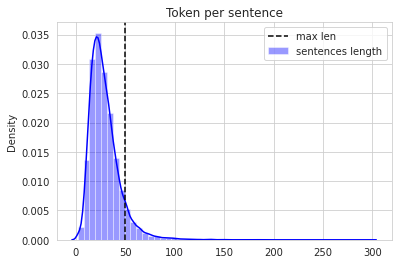

In [ ]:
sns.distplot(sentences_len, hist=True, kde=True, color="b", label="sentences length")
plt.axvline(x=max_seq_len, color="k", linestyle="--", label="max len")
plt.title("Token per sentence")
plt.legend()
plt.show()

In [ ]:
sent_less_than_msl = [s for s in docs_train.sentences if len(s) <= 50]
perc_sent = round(len(sent_less_than_msl) / len(docs_train.sentences) * 100)
print("The", perc_sent,"%", "of sentences has less or equal than 50 tokens.")

The 92 % of sentences has less or equal than 50 tokens.


# PREPROCESSING FOR TRAINING

Before feeding the data to the model we need to further preprocess the text. In order to feed the data to the Bi-LSTM model, we need to ensure that all text should be of the same length. The method sequence **pad_sequences()** and variable *max_seq_len* are used for this purpose. The text which are shorter than fixed *max_seq_len* value are padded to get them to the same length, whereas text which are longer than *max_seq_len* are truncated. Then, we use the **TextVectorization** layer from tf as text encoder. This allows to transforms a sequences of strings into a list of token indices. Every token in a sequence is mapped to a corresponding integer ID. This saves a lot of memory. 

In [ ]:
# Padding sentences to the max_seq_len
from keras.preprocessing.sequence import pad_sequences

X_train_padded = pad_sequences(maxlen=max_seq_len, sequences=docs_train.sentences, padding="post", value="", dtype=object, truncating = "post")
X_test_padded =  pad_sequences(maxlen=max_seq_len, sequences=docs_test.sentences, padding="post", value="", dtype=object, truncating = "post")
X_dev_padded =  pad_sequences(maxlen=max_seq_len, sequences=docs_dev.sentences, padding="post", value="", dtype=object, truncating = "post")

In [ ]:
X_test_padded[812]

array(['NAAG', 'can', 'activate', 'these', 'presynaptic', 'receptors',
       'with', 'extremely', 'high', 'affinity', 'and', 'with',
       'characteristics', 'compatible', 'with', 'the', 'reported',
       'mGluR3', 'pharmacology', '.', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', ''], dtype=object)

In [ ]:
# Vocabulary Key:Tag -> Value:ID_tag & Vocabulary Key:ID_tag -> Value:Tag
tag2idx, idx2tag = docs_train.from_labels_2_idx()

In [ ]:
# Padding and encoding the target variable
y_train = docs_train.padded_and_encoded_labels(tag2idx, max_seq_len)
y_test = docs_test.padded_and_encoded_labels(tag2idx, max_seq_len)
y_dev = docs_dev.padded_and_encoded_labels(tag2idx, max_seq_len)

In [ ]:
# Decoding one-hot vectors
y_train = np.argmax(y_train, axis = -1)
y_test = np.argmax(y_test, axis = -1)
y_dev = np.argmax(y_dev, axis = -1)

In [ ]:
# Build the text encoder layer
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(split=None, standardize = None, ngrams=None,
    max_tokens=None, output_mode = "int")

In [ ]:
# Create the vocabulary
encoder.adapt(docs_train.tokens)

In [ ]:
# Extract the vocabulary
voc = np.array(encoder.get_vocabulary())

In [ ]:
# Explore first 30 more frequent words in the train set, first entry reserved for PAD
voc[:30] 

array(['', '[UNK]', '.', ',', '-', 'of', 'the', 'and', ')', '(', 'in',
       'to', 'a', 'with', 'for', 'that', 'by', 'The', 'is', 'was', 'were',
       'as', '/', '1', '2', 'on', 'from', 'are', '3', 'an'], dtype='<U44')

In [ ]:
# A dict mapping words to their IDs
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
# A dict mapping IDs to their words
idx2word = {i: w for w, i in word_index.items()}

In [ ]:
# Map padded sentences to integer IDs
X_train = encoder(np.array(X_train_padded))
X_test = encoder(np.array(X_test_padded))
X_dev = encoder(np.array(X_dev_padded))

In [ ]:
# Decoding in the test set; some words that are OOV are decoded as [UNK]
for n in range(3):
  print("Original: ", docs_test.sentences[n])
  print("Round-trip: ", " ".join(voc[X_test[n]]))
  print() 

Original:  ['Effects', 'of', 'docosahexaenoic', 'acid', 'and', 'methylmercury', 'on', 'child', "'", 's', 'brain', 'development', 'due', 'to', 'consumption', 'of', 'fish', 'by', 'Finnish', 'mother', 'during', 'pregnancy', ':', 'a', 'probabilistic', 'modeling', 'approach', '.']
Round-trip:  Effects of docosahexaenoic acid and methylmercury on child ' s brain development due to consumption of fish by [UNK] mother during pregnancy : a probabilistic modeling approach .                      

Original:  ['Fish', 'contains', 'both', 'beneficial', 'substances', 'e', '.', 'g', '.', 'docosahexaenoic', 'acids', 'but', 'also', 'harmful', 'compounds', 'e', '.', 'g', '.', 'methylmercury', '.']
Round-trip:  Fish contains both beneficial substances e . g . docosahexaenoic acids but also harmful compounds e . g . methylmercury .                             

Original:  ['Importantly', ',', 'the', 'health', 'effects', 'caused', 'by', 'these', 'two', 'substances', 'can', 'be', 'evaluated', 'in', 'one', '

In [ ]:
print("The word 'cell' is identified by the index: {}".format(word_index["cell"]))
print("The labels 'B-Chemical' is identified by the index: {}".format(tag2idx["B-Chemical"]))

The word 'cell' is identified by the index: 39
The labels 'B-Chemical' is identified by the index: 1


# IMPLEMENTING MODEL ARCHITECTURE

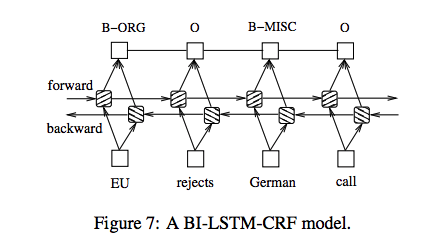


Model Architecture 

In [ ]:
# Hyperparams initialization
BATCH_SIZE = 32
EPOCHS = 10
EMBEDDING = 300

In [ ]:
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input
from tf2crf import CRF, ModelWithCRFLoss
#from keras.layers import Masking

In [ ]:
# Model definition
def build_model(max_seq_len, opt=None):
  input = Input(shape=(max_seq_len,), dtype="int32") #timesteps
  #mask = Masking(mask_value=0)(input)
  model = Embedding(input_dim=len(word_index), output_dim=EMBEDDING,
                    input_length=max_seq_len, mask_zero = True)(input) 
  model = Bidirectional(LSTM(units=256, return_sequences=True,
                    recurrent_dropout=0.2))(model)
  model = Bidirectional(LSTM(units=125, return_sequences=True,
                    recurrent_dropout=0.2))(model)
  #dp = Dropout(0.4) (model) 
  out = (Dense(len(tag2idx), activation=None))(model)
  crf = CRF(dtype='float32') # CRF layer
  output = crf(out)
  base_model = Model(input, output)
  model = ModelWithCRFLoss(base_model)

  if opt:
    opt = opt
  else:
    opt = Adam()
  
  model.compile(optimizer=opt)
  print(base_model.summary())
  return model

In [ ]:
"""#try different optimizers

for OPTIMAZER in [SGD(), Adam(), RMSprop()]:
  print()
  model.compile(optimizer=OPTIMAZER, loss= crf_losses.crf_loss, metrics=[crf_accuracies.crf_viterbi_accuracy])
  model.fit(X_train, np.array(y_train), epochs=5, batch_size=32, verbose=1, validation_data=(X_val, np.array(y_val)))
  score = model.evaluate(X_test, np.array(y_test))
  print()
  print("OPTIMEZER: ", OPTIMAZER)
  print("\nTest score ", score[0])
  print("Test accuracy: ", score[1])"""

'#try different optimizers\n\nfor OPTIMAZER in [SGD(), Adam(), RMSprop()]:\n  print()\n  model.compile(optimizer=OPTIMAZER, loss= crf_losses.crf_loss, metrics=[crf_accuracies.crf_viterbi_accuracy])\n  model.fit(X_train, np.array(y_train), epochs=5, batch_size=32, verbose=1, validation_data=(X_val, np.array(y_val)))\n  score = model.evaluate(X_test, np.array(y_test))\n  print()\n  print("OPTIMEZER: ", OPTIMAZER)\n  print("\nTest score ", score[0])\n  print("Test accuracy: ", score[1])'

# TRAINING

In [ ]:
dir_output = "/content/drive/MyDrive/BIO-NER-project/ft-bi-lstm-crf-BC4CHEMD.h5"

In [ ]:
# Early stopping stops the training process when val_loss is not improving
# ModelCkpt save only the best model (model with lowest val_loss)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor="val_crf_loss_val", patience=2)
#model_save = ModelCheckpoint(dir_output, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

In [ ]:
def ignoring_padding(y_pred,y_test):
  """This function allows to compare predicted labels with true labels discarding padding"""
  real_pred = []
  y_test_nozeroes = [[l for l in s if l != 0] for s in y_test] # Delete padding label in the original sentences
  for s, s1 in zip(y_pred, y_test_nozeroes):
    s = s.tolist() 
    real_s =  s[:len(s1)] # Delete padding from the predicted sentences
    real_pred.append(real_s)
  pred_tag = [[idx2tag[i] for i in row] for row in real_pred]
  y_test_tag = [[idx2tag[i] for i in row] for row in y_test_nozeroes]
  return pred_tag, y_test_tag

In [ ]:
%%capture
!pip3 install seqeval

In [ ]:
from keras.callbacks import Callback
from seqeval.metrics import f1_score

class Metrics(Callback):
    """Custom F1 metric to look after the performance on the validation set during the training"""
    def __init__(self, validation):   
        super(Metrics, self).__init__()
        self.validation = validation    
            
        print('validation shape', len(self.validation[0]))
        
    def on_train_begin(self, logs={}):        
        self.val_f1s = []
     
    def on_epoch_begin(self, epoch, logs={}):
        val_targ = self.validation[1]   
        val_predict = self.model.predict(self.validation[0])[0]
        y_true, y_hat = ignoring_padding(val_predict, val_targ)
        val_f1 = f1_score(y_true, y_hat)
        
        
        self.val_f1s.append(round(val_f1, 6))
        
 
        print(f' — val_f1: {val_f1} ')

In [ ]:
# Customised callbacks
mycallbacks = [Metrics(validation=(X_dev, y_dev)), early_stopping]

validation shape 30639


In [ ]:
model = build_model(max_seq_len, RMSprop())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 300)           12159000  
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 512)           1140736   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 250)           638000    
_________________________________________________________________
dense (Dense)                (None, 50, 4)             1004      
_________________________________________________________________
crf (CRF)                    ((None, 50), (None, 50, 4 18        
Total params: 13,938,758
Trainable params: 13,938,756
Non-trainable params: 2
__________________________________________

In [ ]:
%%time
# Fit network - F1-score is measured on the validation data
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=(X_dev, y_dev), callbacks = mycallbacks)

 — val_f1: 0.026893087671018334 
Epoch 1/10
959/959 [==============================] - 755s 787ms/step - crf_loss: 2.6959 - accuracy: 0.9675 - val_crf_loss_val: 0.2718 - val_val_accuracy: 0.9772
 — val_f1: 0.7172785651433171 
Epoch 2/10
959/959 [==============================] - 758s 790ms/step - crf_loss: 0.7165 - accuracy: 0.9894 - val_crf_loss_val: 0.2084 - val_val_accuracy: 0.9797
 — val_f1: 0.7644362969752521 
Epoch 3/10
959/959 [==============================] - 745s 777ms/step - crf_loss: 0.4345 - accuracy: 0.9930 - val_crf_loss_val: 0.5537 - val_val_accuracy: 0.9745
 — val_f1: 0.7389611014056063 
Epoch 4/10
959/959 [==============================] - 742s 774ms/step - crf_loss: 0.3191 - accuracy: 0.9948 - val_crf_loss_val: 0.1259 - val_val_accuracy: 0.9774
 — val_f1: 0.7419937650559728 
Epoch 5/10
959/959 [==============================] - 756s 788ms/step - crf_loss: 0.2362 - accuracy: 0.9961 - val_crf_loss_val: 0.3668 - val_val_accuracy: 0.9787
 — val_f1: 0.7600762964151381 
Ep

In [ ]:
#model.summary()

In [ ]:
model.save_weights(dir_output)

**Output** = viterbi_sequence, inputs(the output of the previous
layer), sequence_lengths (mask), self.transitions (crf transmission
parameters)

# LEARNING CURVES

In [ ]:
#history.history

In [ ]:
history.epoch

[0, 1, 2, 3, 4, 5]

In [ ]:
epochs = len(history.epoch)
epochs = range(1,epochs+1)

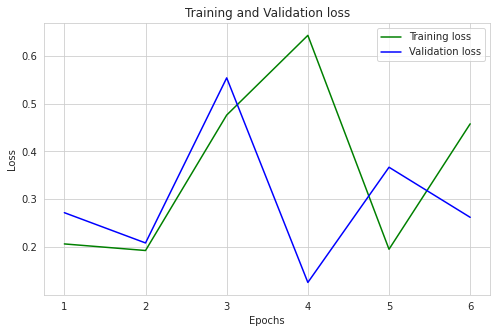

In [ ]:
plt.rcParams["figure.figsize"] = [8,5]
loss_train = history.history["crf_loss"]
loss_val = history.history["val_crf_loss_val"]
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.xticks(np.arange(1, len(epochs)+1))
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

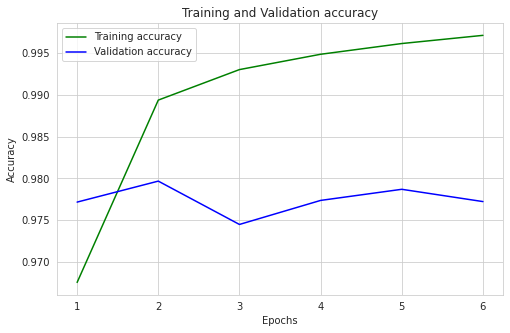

In [ ]:
plt.rcParams["figure.figsize"] = [8,5]
loss_train = history.history["accuracy"]
loss_val = history.history["val_val_accuracy"]
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
plt.xticks(np.arange(1, len(epochs)+1))
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# PREDICTION AND EVALUATION

In [ ]:
#model = build_model(max_seq_len, RMSprop())

In [ ]:
dir_output

'/content/drive/MyDrive/BIO-NER-project/bi-lstm-crf-BC4CHEMD.h5'

In [ ]:
# This saves me
model.built = True 

In [ ]:
model.load_weights(dir_output)

In [ ]:
X_test = X_test[:120*BATCH_SIZE]
y_test = y_test[:120*BATCH_SIZE]

In [ ]:
%%time
y_pred = model.predict(X_test)[0]

CPU times: user 12.9 s, sys: 1.65 s, total: 14.5 s
Wall time: 10 s


In [ ]:
y_hat, y_true = ignoring_padding(y_pred, y_test)

# REPORT

In [ ]:
from seqeval.metrics import classification_report

In [ ]:
print('\033[1m' + "Classification report for #1 model without LR optimization: ")
print('\033[0m')
print(classification_report(y_true, y_hat))

Classification report for #1 model without LR optimization: 

              precision    recall  f1-score   support

    Chemical       0.77      0.83      0.80      3337

   micro avg       0.77      0.83      0.80      3337
   macro avg       0.77      0.83      0.80      3337
weighted avg       0.77      0.83      0.80      3337



In [ ]:
print("F1-score(relaxed): {:0.3}".format(f1_score(y_true, y_hat, average = "weighted")))

F1-score(relaxed): 0.798


In [ ]:
from seqeval.scheme import IOB2
print('\033[1m' + "Classification report for #1 model without LR optimization (exact match): ")
print('\033[0m')
print(classification_report(y_true, y_hat, scheme=IOB2, mode="strict"))

Classification report for #1 model without LR optimization (exact match): 

              precision    recall  f1-score   support

    Chemical       0.77      0.83      0.80      3337

   micro avg       0.77      0.83      0.80      3337
   macro avg       0.77      0.83      0.80      3337
weighted avg       0.77      0.83      0.80      3337



In [ ]:
print("F1-score: {:0.3}".format(f1_score(y_true, y_hat, average = "weighted", scheme=IOB2, mode="strict")))

F1-score: 0.798


# COMPARE RESULTS

In [ ]:
i = 18  #prendi il chunck di frasi da 390 a 390+32
p = model.predict(X_test[i:i+BATCH_SIZE])[0][0]
#p = np.argmax(p, axis=-1)

In [ ]:
# From tensor to array
X_true1 = tf.make_tensor_proto(X_test)
X_true1 = tf.make_ndarray(X_true1)

In [ ]:
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*45)
for w, true, pred in zip(X_true1[i], y_true[i], p):
    if w != 0:
      print("{:15}:{:15} ({})".format(idx2word[w], idx2tag[pred], true))

Word            Pred : (True)
Endothelial    :O               (O)
nitric         :B-Chemical      (B-Chemical)
oxide          :I-Chemical      (I-Chemical)
synthase       :O               (O)
genotypes      :O               (O)
and            :O               (O)
haplotypes     :O               (O)
modify         :O               (O)
the            :O               (O)
responses      :O               (O)
to             :O               (O)
sildenafil     :B-Chemical      (B-Chemical)
in             :O               (O)
patients       :O               (O)
with           :O               (O)
erectile       :O               (O)
dysfunction    :O               (O)
.              :O               (O)


# EXPLORING EMBEDDING LAYER

In [ ]:
# Embeddings has a shape of (vocab_size, embedding_dim)
embeddings = model.layers[0].get_weights()[0] #embeddings

In [ ]:
# Explore dictionary
word_index.items()

dict_items([('', 0), ('[UNK]', 1), ('.', 2), (',', 3), ('-', 4), ('of', 5), ('the', 6), ('and', 7), (')', 8), ('(', 9), ('in', 10), ('to', 11), ('a', 12), ('with', 13), ('for', 14), ('that', 15), ('by', 16), ('The', 17), ('is', 18), ('was', 19), ('were', 20), ('as', 21), ('/', 22), ('1', 23), ('2', 24), ('on', 25), ('from', 26), ('are', 27), ('3', 28), ('an', 29), ('or', 30), ('be', 31), ('at', 32), ('In', 33), ('0', 34), ('cells', 35), ('this', 36), (':', 37), ('%', 38), ('cell', 39), ('activity', 40), ('5', 41), ('4', 42), ('study', 43), ('which', 44), ('A', 45), ('have', 46), ('effects', 47), ('we', 48), ('induced', 49), ('not', 50), ('these', 51), ("'", 52), ('protein', 53), ('been', 54), ('beta', 55), ('using', 56), ('expression', 57), ('results', 58), ('also', 59), ('has', 60), ('We', 61), ('6', 62), ('high', 63), ('their', 64), ('treatment', 65), ('effect', 66), ('between', 67), ('alpha', 68), ('This', 69), ('used', 70), ('both', 71), ('human', 72), ('than', 73), ('levels', 74),

In [ ]:
# Word2idx is a mapping (i.e. dict) from words to their index, e.g. "cell": 69
words_embeddings = {w:embeddings[idx] for w, idx in word_index.items()}

In [ ]:
print("What is the vector representation for the word 'cell'?")
#words_embeddings["cell"]

What is the vector representation for the word 'cell'?


# TUNING LEARNING RATE

LRFinder implements a Keras Callback which tracks the loss associated with a learning rate varied linearly over a defined range. Implementation by https://github.com/WittmannF

In [ ]:
from lrfinder import LRFinder

In [ ]:
"""# Get an instance of LRTest class
lr_finder = LRFinder(min_lr=1e-4, max_lr=1)

# Build the model again
model2 = build_model(max_seq_len, RMSprop())

# Perform the LR range test 
history = model2.fit(X_train, np.array(y_train), epochs=10, batch_size=32, verbose=0, callbacks=[lr_finder])"""

'# Get an instance of LRTest class\nlr_finder = LRFinder(min_lr=1e-4, max_lr=1)\n\n# Build the model again\nmodel2 = build_model(max_seq_len, RMSprop())\n\n# Perform the LR range test \nhistory = model2.fit(X_train, np.array(y_train), epochs=10, batch_size=32, verbose=0, callbacks=[lr_finder])'

# TRAIN THE MODEL WITH OPTIMAL LR

To avoid overfitting, it will be choose a learning rate that is a little futher than the optimal value.

In [ ]:
"""# Build the model with the optimal lr
model3 = build_model(max_seq_len, RMSprop(lr=10**-2.8))

# Train the model
model3.fit(X_train, y_train, epochs=5, batch_size=BATCH_SIZE, verbose=1, validation_data=(X_val, y_val), callbacks=mycallbacks)"""

'# Build the model with the optimal lr\nmodel3 = build_model(max_seq_len, RMSprop(lr=10**-2.8))\n\n# Train the model\nmodel3.fit(X_train, y_train, epochs=5, batch_size=BATCH_SIZE, verbose=1, validation_data=(X_val, y_val), callbacks=mycallbacks)'

In [ ]:
%%time
y_pred = model.predict(X_test)[0]

CPU times: user 12 s, sys: 1.62 s, total: 13.6 s
Wall time: 9.1 s


In [ ]:
y_hat, y_true = ignoring_padding(y_pred, y_test)

In [ ]:
print('\033[1m' + "Classification report for #2 model with LR optimization: ")
print('\033[0m')
print(classification_report(y_true, y_hat))

Classification report for #2 model with LR optimization: 

              precision    recall  f1-score   support

    Chemical       0.77      0.83      0.80      3337

   micro avg       0.77      0.83      0.80      3337
   macro avg       0.77      0.83      0.80      3337
weighted avg       0.77      0.83      0.80      3337



In [ ]:
print("F1-score(relaxed): {:0.3}".format(f1_score(y_true, y_hat, average = "weighted")))

F1-score(relaxed): 0.798


In [ ]:
print('\033[1m' + "Classification report for #1 model without LR optimization (exact match): ")
print('\033[0m')
print(classification_report(y_true, y_hat, scheme=IOB2, mode="strict"))

Classification report for #1 model without LR optimization (exact match): 

              precision    recall  f1-score   support

    Chemical       0.77      0.83      0.80      3337

   micro avg       0.77      0.83      0.80      3337
   macro avg       0.77      0.83      0.80      3337
weighted avg       0.77      0.83      0.80      3337



In [ ]:
from seqeval.scheme import IOB2
print("F1-score: {:0.3}".format(f1_score(y_true, y_hat, average = "weighted", scheme=IOB2, mode="strict")))

F1-score: 0.798


In [ ]:
import sys

print('Saving classification report on file...')

original_stdout = sys.stdout 

with open('/content/drive/MyDrive/output.txt', 'a') as f:
  sys.stdout = f # Change the standard output to the file we created.
  print('\033[1m' + "Classification report Bi-LSTM+CRF for JNLPBA dataset: ")
  print('\033[0m')
  print(classification_report(y_true, y_hat))
  sys.stdout = original_stdout # Reset the standard output to its original value
print("Done.")

Saving classification report on file...
Done.
